In [1]:
import os
import json
import requests
from requests.auth import HTTPBasicAuth

In [2]:
# AOI co-ordinates (created via geojson.io) 

geojson_geometry = {
    "type": "Polygon",
    "coordinates": [
        [ 
            [-124.222412109375,42.0125705565935],
            [-124.47509765625,40.455307212131494],
            [-124.38720703124999,40.27952566881291],
            [-123.760986328125,38.91668153637508],
            [-123.0908203125,38.03078569382294],
            [-122.55249023437501,37.32648861334206],
            [-121.9482421875,36.29741818650811],
            [-120.65185546875,34.56085936708384],
            [-117.12524414062501,32.52828936482526],
            [-114.697265625,32.704111144407406],
            [-114.521484375,32.74108223150125],
            [-114.42260742187499,32.93492866908233],
            [-114.6533203125,33.091541548655215],
            [-114.664306640625,33.394759218577995],
            [-114.510498046875,33.6420625047537],
            [-114.521484375,33.916013113401696],
            [-114.3896484375,33.96158628979907],
            [-114.510498046875,34.043556504127444],
            [-114.093017578125,34.279914398549934],
            [-114.345703125,34.44315867450577],
            [-114.444580078125,34.66935854524543],
            [-114.620361328125,34.867904962568716],
            [-114.59838867187499,35.02099970111467],
            [-119.981689453125,39.01918369029134],
            [-119.981689453125,42.00032514831621],
            [-124.222412109375,42.0125705565935]
        ]
    ]
}

In [3]:
# get images that overlap with our AOI 
geometry_filter = {
    "type": "GeometryFilter",
    "field_name": "geometry",
    "config": geojson_geometry
}

# get images acquired within a date range
date_range_filter = {
    "type": "DateRangeFilter",
    "field_name": "acquired",
    "config": {
        "gte": "2016-01-01T00:00:00.000Z",
        "lte": "2016-12-31T00:00:00.000Z"
    }
}

# only get images which have <50% cloud coverage
cloud_cover_filter = {
    "type": "RangeFilter",
    "field_name": "cloud_cover",
    "config": {
        "lte": 0.5
    }
}

# combine our geo, date, cloud filters
combined_filter = {
    "type": "AndFilter",
    "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [7]:
# API Key stored as an env variable
PLANET_API_KEY = '1f0fcc9d6605435cb6c8064025d33712'

item_type = "PSScene4Band"

# API request object
search_request = {
    "interval": "day",
    "item_types": [item_type], 
    "filter": combined_filter
}

# fire off the POST request
search_result = requests.post('https://api.planet.com/data/v1/quick-search', auth=HTTPBasicAuth(PLANET_API_KEY, ''),json=search_request)

print(json.dumps(search_result.json(), indent=1))

{
 "_links": {
  "_first": "https://api.planet.com/data/v1/searches/c29f07e7bb2a4bde8bf1eae3e4371470/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D",
  "_next": "https://api.planet.com/data/v1/searches/c29f07e7bb2a4bde8bf1eae3e4371470/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6ICIyMDE4LTA2LTI4VDEyOjMyOjIxLjc1ODAwMFoiLCAic29ydF9sYXN0X2lkIjogIjIwMTYwNzE3XzE1MjgwNV8xXzBjNjAiLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D",
  "_self": "https://api.planet.com/data/v1/searches/c29f07e7bb2a4bde8bf1eae3e4371470/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D"
 },
 "features": [
  {
   "_links": {

In [8]:
links = search_result.json()[u"analytic"]["_links"]
self_link = links["_self"]
activation_link = links["activate"]

# Request activation of the 'analytic' asset:
activate_result = requests.get(activation_link,auth=HTTPBasicAuth(PLANET_API_KEY, ''))
  
activation_status_result = requests.get(self_link,auth=HTTPBasicAuth(PLANET_API_KEY, ''))
    
print(activation_status_result.json()["status"])

KeyError: 'analytic'

In [ ]:
download_link = activation_status_result.json()["location"]
print(download_link)

In [18]:
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import rasterio.mask
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show_hist

In [11]:
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_dict(init='epsg:32611'), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0, 0.5, 'Row #')

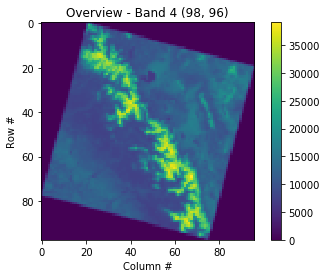

In [14]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as src:
   oviews = src.overviews(1) # list of overviews from biggest to smallest
   oview = oviews[-1] # let's look at the smallest thumbnail
   print('Decimation factor= {}'.format(oview))
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Decimation factor= 81


Text(0, 0.5, 'Row #')

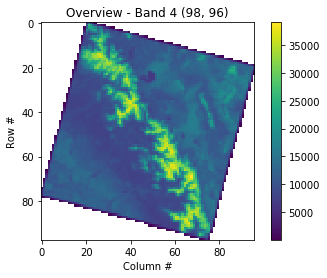

In [17]:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [23]:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f5')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Decimation factor= 81


TypeError: data type "f5" not understood

/opt/anaconda3/envs/w210_geo/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/w210_geo/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


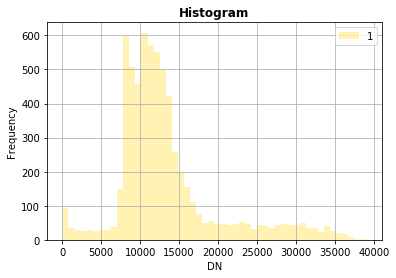

In [21]:
show_hist(thumbnail, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")